# ДОМАШНЕЕ ЗАДАНИЕ 3. Классификация текстовых документов
## Цель работы

Приобрести опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.

## Библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
# Логистическая регрессия, Наивный Байес: модель Бернулли, мультиномиальная модель
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
# Импортим библиотеку чтобы засекать время
import time


RANDOM_STATE = 123

## Вариант

In [3]:
surname = "Панфилкин" # Ваша фамилия

alp = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alp, w))
variant =  sum([d[el] for el in surname.lower()]) % 3 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  3


### Задание 1. Оценка качества классификации текстовых данных (2 балла)

In [7]:
# Загрузка данных из файла data/reviews.tsv (первый столбец - метки классов, второй - тексты)
data = pd.read_csv('data/reviews.tsv', sep='\t', names=['target', 'text'])
# Вытащим X и y из датафрейма
X, y = data['text'], data['target']
# Отобразим датафрейм с данными
data

,target,text
0,0,unless bob crane is someone of particular inte...
1,1,"finds a way to tell a simple story , perhaps t..."
2,0,"ill-considered , unholy hokum ."
3,0,"nijinsky says , 'i know how to suffer' and if ..."
4,1,the auteur's ear for the way fears and slights...
...,...,...
10657,0,"it's mildly sentimental , unabashedly consumer..."
10658,0,so verbally flatfooted and so emotionally pred...
10659,0,alternative medicine obviously has its merits ...
10660,0,a by-the-numbers patient/doctor pic that cover...


In [8]:
# Выведем количество наблюдений в каждом классе
data['target'].value_counts()

0    5331
1    5331
Name: target, dtype: int64

#### 2. Разбивка загруженных данных на обучающее (train, 80%) и тестовое подмножества (test, 20%)

In [9]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=RANDOM_STATE,
    stratify=y # сохраняем баланс классов
)

In [10]:
def get_metrics(model, X_train, y_train, X_test, y_test):
    """
    Функция для расчета метрик в виде словоря
    """
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    start = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return {
        'fit_time': fit_time,
        'score_time': predict_time,
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred)
    }

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
vectorizer_binary = CountVectorizer(binary=True, ngram_range=(1, 1), lowercase=True)

models = {
    "K-ближайших соседей (n=5)": Pipeline([
        ('vectorizer', vectorizer),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),
    "Логистическая регрессия (С=1)": Pipeline([
        ('vectorizer', vectorizer),
        ('model', LogisticRegression(
            penalty='l2',
            fit_intercept=True,
            max_iter=100,
            C=1,
            solver='lbfgs',
            random_state=RANDOM_STATE
        ))
    ]),
    "Наивный Байес: модель Бернулли (a=1)": Pipeline([
        ('vectorizer', vectorizer_binary),
        ('model', BernoulliNB(alpha=1))
    ]),
    "Наивный Байес: полиномиальная модель (a=1)": Pipeline([
        ('vectorizer', vectorizer),
        ('model', MultinomialNB(alpha=1))
    ])
}

# Определим качество моделей как датафрейм
metrics_dict = {}

for name, model in models.items():
    # Раскроем пайплайн и отдельно обучим векторайзер,
    # чтобы время обучения векторайзера не учитывалось в метриках
    X_train_ = model['vectorizer'].fit_transform(X_train)
    X_test_ = model['vectorizer'].transform(X_test)
    metrics = get_metrics(model['model'], X_train_, y_train, X_test_, y_test)
    metrics_dict[name] = metrics
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

,fit_time,score_time,test_balanced_accuracy,test_recall,test_precision,test_f1
K-ближайших соседей (n=5),0.002871,1.513655,0.701368,0.718574,0.694470,0.706316
Логистическая регрессия (С=1),0.385312,0.001000,0.759496,0.764540,0.756732,0.760616
Наивный Байес: модель Бернулли (a=1),0.006011,0.001992,0.774956,0.756098,0.785575,0.770554
Наивный Байес: полиномиальная модель (a=1),0.005004,0.001964,0.780115,0.766417,0.787850,0.776985


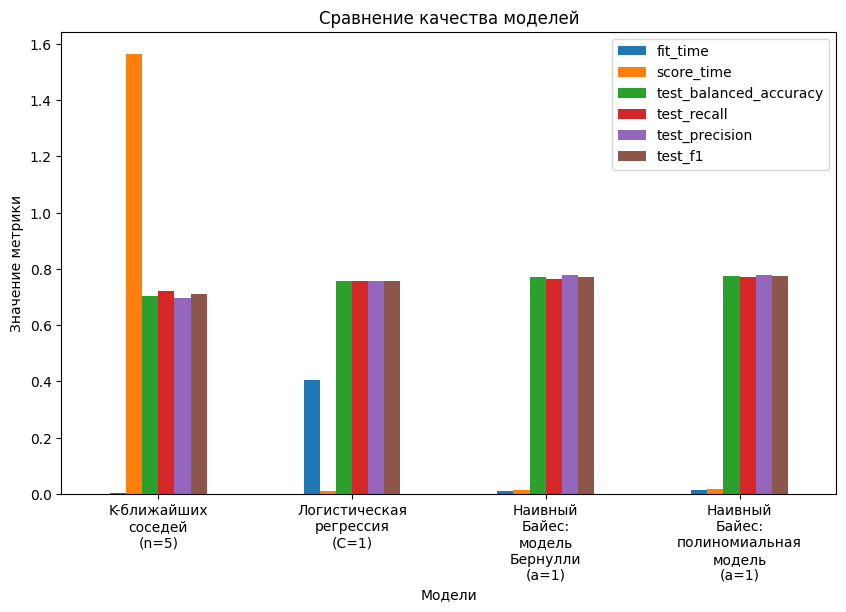

In [18]:
# Отобразим metrics_df в виде столбчатой диаграммы
# для каждого метода отобразим все метрики через matplotlib
ax = metrics_df.plot.bar(rot=90, figsize=(10, 6))
ax.set_title('Сравнение качества моделей')
ax.set_xlabel('Модели')
ax.set_ylabel('Значение метрики')
ax.legend()
# Поворот подписей моделей на 90 градусов
plt.xticks(rotation=0)
# Установим другие подписи по оси Y добавив \n для переноса строк
ax.set_xticklabels([name.replace(' ', '\n') for name in metrics_df.index])
plt.show()

### Задание 2. Оценка качества классификации текстовых данных посредством кросс-валидации (2 балла)

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate


# Определим качество моделей как датафрейм
metrics_dict = {}

# Определим стратифицированную кросс-валидацию
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    # Раскроем пайплайн и отдельно обучим векторайзер,
    # чтобы время обучения векторайзера не учитывалось в метриках
    X_ = model['vectorizer'].fit_transform(X)

    # Вычислим метрики через кросс-валидацию из sklearn
    metrics = cross_validate(
        model['model'], X_, y, cv=skf,
        scoring=['balanced_accuracy', 'recall', 'precision', 'f1']
    )
    # Сохраним средние значения метрик по фолдам
    metrics_dict[name] = {metric:value.mean() for metric, value in metrics.items()}

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

,fit_time,score_time,test_balanced_accuracy,test_recall,test_precision,test_f1
K-ближайших соседей (n=5),0.006830,1.873150,0.704466,0.721067,0.697961,0.709275
Логистическая регрессия (С=1),0.358747,0.016141,0.756989,0.758207,0.756499,0.757313
Наивный Байес: модель Бернулли (a=1),0.014498,0.018819,0.772935,0.763837,0.778135,0.770838
Наивный Байес: полиномиальная модель (a=1),0.006638,0.010775,0.775654,0.770590,0.778529,0.774473


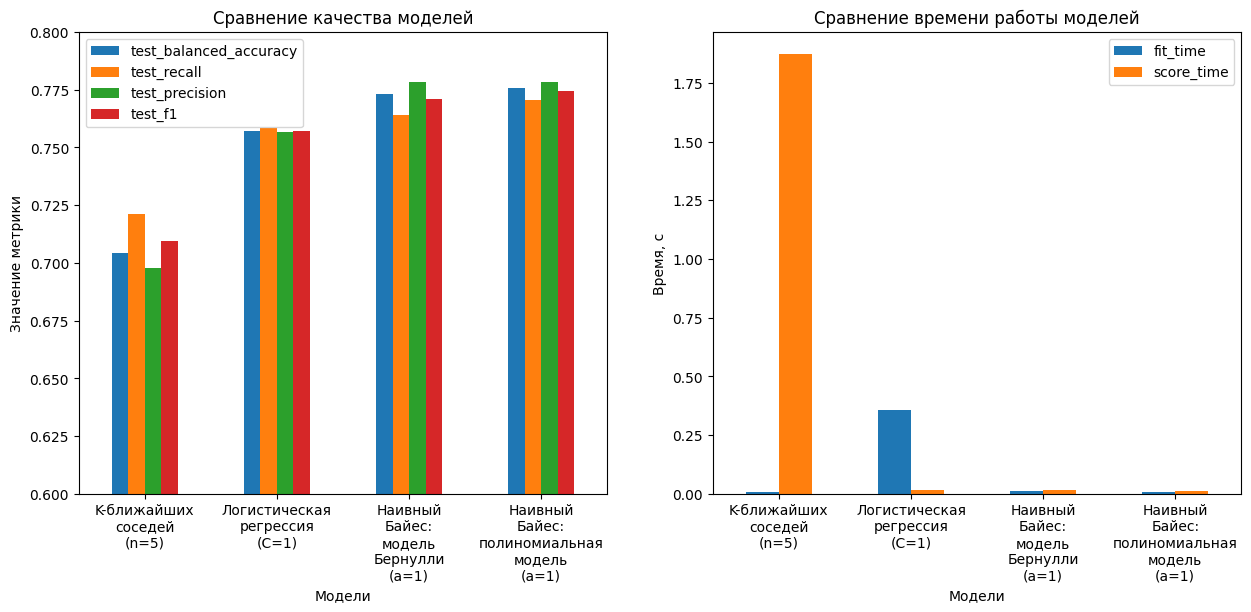

In [43]:
# Отобразим metrics_df в виде столбчатой диаграммы
# для каждого метода отобразим все метрики через matplotlib
# Два графика, один для метрик точности, другой - для времени
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Для метрик точности
ax = metrics_df.drop(columns=['fit_time', 'score_time']).plot.bar(rot=90, ax=axes[0])
ax.set_ylim(0.6, 0.8)
ax.set_title('Сравнение качества моделей')
ax.set_xlabel('Модели')
ax.set_ylabel('Значение метрики')
ax.legend()
# Установим другие подписи по оси Y добавив \n для переноса строк
ax.set_xticklabels([name.replace(' ', '\n') for name in metrics_df.index])
plt.sca(ax)
plt.xticks(rotation=0)

# Для времени
ax = metrics_df[['fit_time', 'score_time']].plot.bar(rot=90, ax=axes[1])
ax.set_title('Сравнение времени работы моделей')
ax.set_xlabel('Модели')
ax.set_ylabel('Время, с')
ax.legend()
# Установим другие подписи по оси Y добавив \n для переноса строк
ax.set_xticklabels([name.replace(' ', '\n') for name in metrics_df.index])
# Поворот подписей моделей на 90 градусов для оси ax
plt.sca(ax)
plt.xticks(rotation=0)
plt.show()

In [62]:
# Используем GridSearchCV для подбора гиперпараметров
# K-ближайших соседей: количество соседей: np.arange(1, 150, 20)
# Логистическая регрессия: коэффициент регуляризации: np.logspace(-2, 10, 8, base=10)
# Наивный Байес: полиномиальная модель и модель Бернулли: сглаживающий параметр: np.logspace(-4, 1, 8, base=10)

from sklearn.model_selection import GridSearchCV

# Определим качество моделей как датафрейм
metrics_dict = {}

# Определим стратифицированную кросс-валидацию
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

# Определим сетку гиперпараметров
param_grid = {
    'K-ближайших соседей': {
        'model__n_neighbors': np.arange(1, 150, 20)
    },
    'Логистическая регрессия': {
        'model__C': np.logspace(-2, 10, 13, base=10)
        # 'model__C': np.logspace(-2, 10, 8, base=10)
    },
    'Наивный Байес: полиномиальная модель': {
        'model__alpha': np.logspace(-4, 1, 12, base=10)
        # 'model__alpha': np.logspace(-4, 1, 8, base=10)
    },
    'Наивный Байес: модель Бернулли': {
        'model__alpha': np.logspace(-4, 1, 12, base=10)
    }
}

# Словарь для хранения результатов
scores = {}

for model, model_name in (pb:=tqdm(zip(models.values(), param_grid.keys()), total=len(models))):
    # Используем кросс-валидацию для подбора гиперпараметров
    gs = GridSearchCV(
        model,
        param_grid=param_grid[model_name],
        scoring='balanced_accuracy',
        cv=skf,
        refit=False, # Не обучаем модель на всех данных в конце (Экономим время)
        return_train_score=True, # Возвращаем значения метрики на обучающей выборке
    )
    # Обучим модель
    pb.set_description(f'Обучение {model_name}')
    gs.fit(X_train, y_train)
    # Сохраним результаты
    scores[model_name] = {
        'train_score': gs.cv_results_['mean_train_score'],
        'test_score': gs.cv_results_['mean_test_score'],
        'best_param_index': gs.best_index_,
    }

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

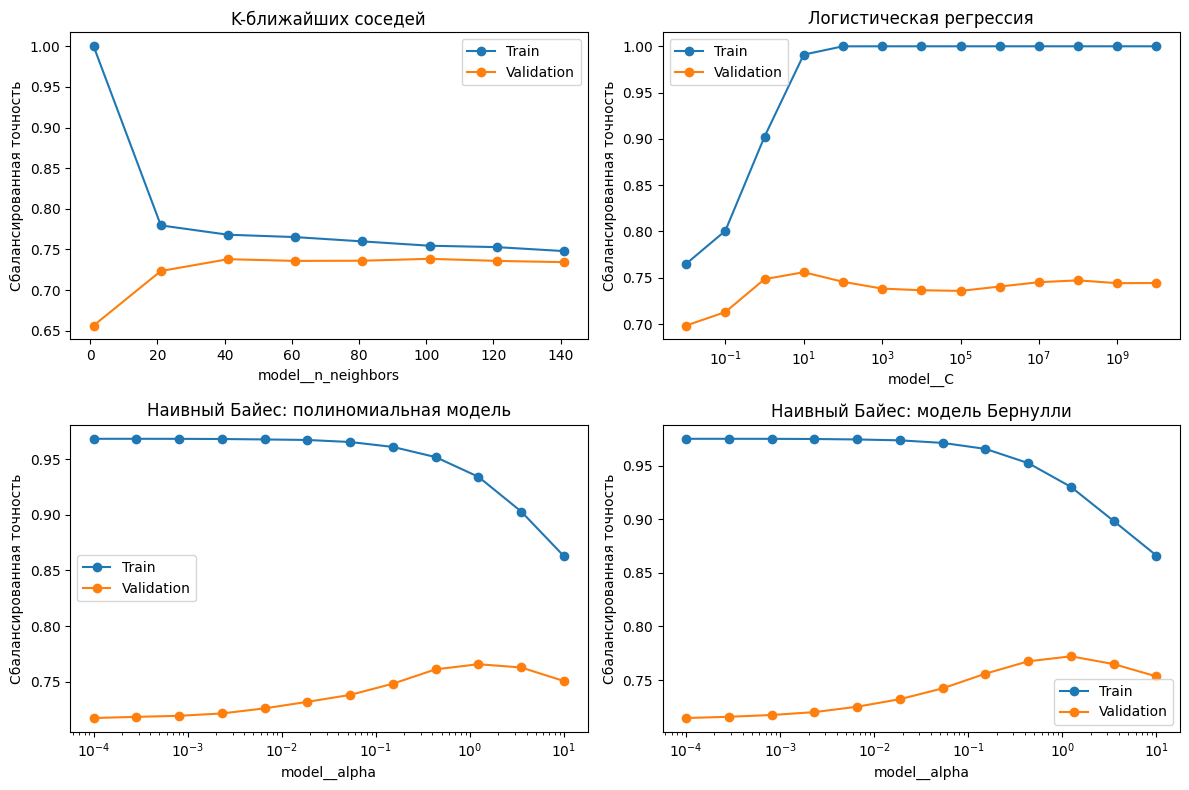

In [64]:
# 4 графика на одном полотне 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
xscales = ['linear', 'log', 'log', 'log']
model_names = list(scores.keys())

for ax, xscale, model_name in zip(axes, xscales, model_names):
    # Построим график зависимости метрики от гиперпараметра
    ax.plot(
        param_grid[model_name][list(param_grid[model_name].keys())[0]],
        scores[model_name]['train_score'],
        label='Train', marker='o'
    )
    ax.plot(
        param_grid[model_name][list(param_grid[model_name].keys())[0]],
        scores[model_name]['test_score'],
        label='Validation', marker='o'
    )
    ax.set_title(model_name)
    ax.set_xlabel(list(param_grid[model_name].keys())[0])
    ax.set_ylabel('Сбалансированная точность')
    ax.set_xscale(xscale)
    ax.legend()
# Фиксим пересечение подписей
plt.tight_layout()
plt.show()


In [65]:
# Определим лучшие параметры для каждой модели
for model_name, metrics in scores.items():
    best_param_index = metrics['best_param_index']
    best_param = list(param_grid[model_name].values())[0][best_param_index]
    param_name = list(param_grid[model_name].keys())[0].replace('model__', '')
    # Значение в жкспоненциальной форме
    print(f'Лучший параметр для {model_name}: {param_name} = {best_param:.2f}')

Лучший параметр для K-ближайших соседей: n_neighbors = 101.00
Лучший параметр для Логистическая регрессия: C = 10.00
Лучший параметр для Наивный Байес: полиномиальная модель: alpha = 1.23
Лучший параметр для Наивный Байес: модель Бернулли: alpha = 1.23


In [61]:
np.arange(1, 150, 20)
np.logspace(-2, 10, 13, base=10)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])